<a href="https://colab.research.google.com/github/vk18mishra/Densely-Connected-Neural-Networks/blob/main/Densely_Connected_Neural_Networks_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [ ]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 90
l = 6
num_filter = 35
compression = 1.0
dropout_rate = 0.2

In [ ]:
def preprocess_data(data_set):
    mean = np.array([125.3, 123.0, 113.9])
    std = np.array([63.0, 62.1, 66.7])

    data_set = data_set - mean
    data_set = data_set / std
    return data_set

In [ ]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

170500096/170498071 [==============================] - 4s 0us/step


In [ ]:
img_height, img_width, channel

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


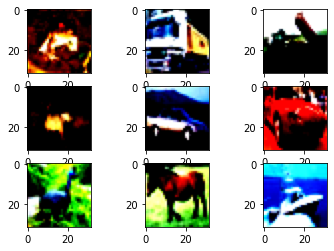

In [ ]:
#Source: https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i])
plt.show()

In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [ ]:
X_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10)

In [ ]:
(X_train.shape, y_train.shape), (x_val.shape, y_val.shape)

(((45000, 32, 32, 3), (45000, 10)), ((5000, 32, 32, 3), (5000, 10)))

In [ ]:
# set up image augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.125,
    height_shift_range=0.125,
    zoom_range=0.1,
    #shear_range = 15
    fill_mode='nearest'
    #rescale=1./255
    )

# test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen.fit(X_train)
# test_datagen.fit(X_test)

In [ ]:
val_datagen = ImageDataGenerator(horizontal_flip=True)
val_datagen.fit(x_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


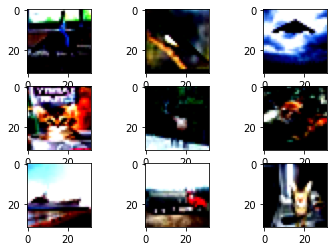

In [ ]:
for X_batch, y_batch in val_datagen.flow(x_val, y_val, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break

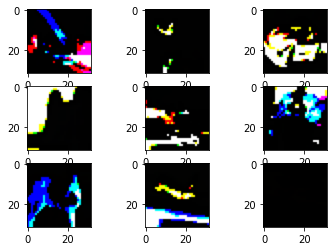

In [ ]:
#Source: https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-
# see example augmentation images
for X_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        # if dropout_rate>0:
        #     Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    # if dropout_rate>0:
    #      Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)  #, strides=None, padding='valid', data_format='channels_first'
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)

    # temp = Conv2D(num_classes, kernel_size = (2,2))(AvgPooling)
    # output = Activation('softmax')(temp)
    # flat = Flatten()(output)

    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [ ]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

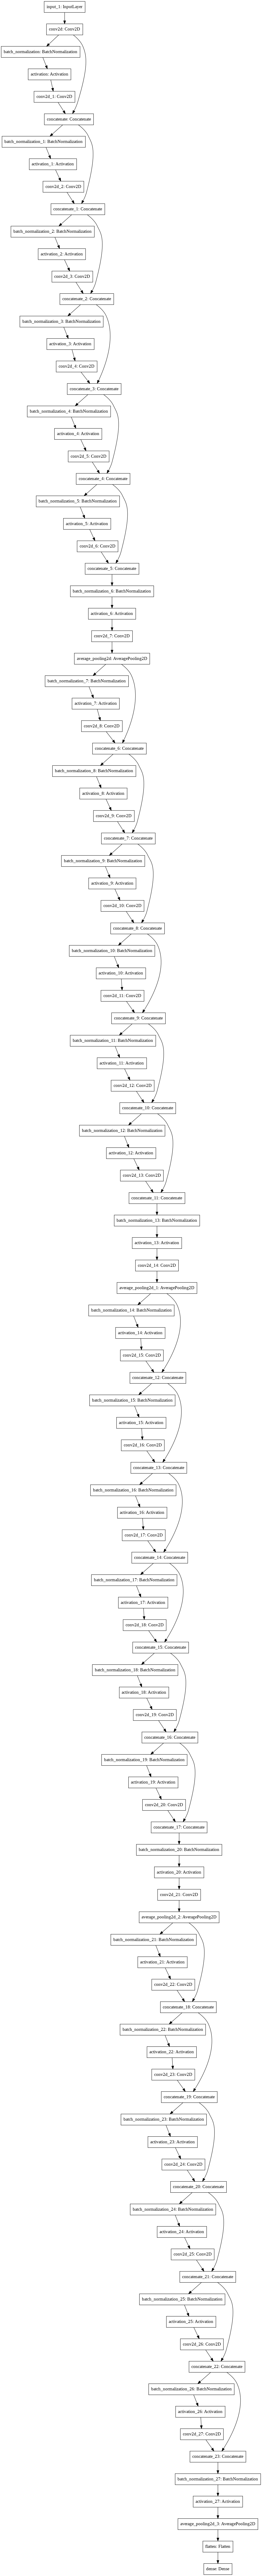

In [ ]:
#drawing models
tf.keras.utils.plot_model(
 model,
 show_shapes=False,
 show_layer_names=True,
 rankdir='TB',
 expand_nested=False,
 dpi=96
)

In [ ]:
print(len(model.layers))

115


In [ ]:
# determine Loss function and Optimizer
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              #optimizer=SGD(lr = 0.1, momentum = 0.9, nesterov = True),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, CSVLogger
def decay_fn(epoch, lr):
    if epoch < 35:
        return 0.001
    elif epoch >= 35 and epoch < 60:
        return 0.0001
    else:
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

In [ ]:
filepath = "{epoch:03d}-{val_accuracy:.3f}.hdf5"
checkpoint_1 = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, verbose = 1)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr = 0.000001, verbose=1)
csv_log = CSVLogger('training_1.log')

**First Run - 93 Epochs**

In [ ]:
epochs = 100

In [ ]:
# train with image augmentation
%%time
history=model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch = (len(X_train)/batch_size), epochs=epochs, validation_data=(x_val, y_val), 
                    verbose=1, callbacks = [checkpoint_1, lr_scheduler, csv_log])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
704/703 [==============================] - ETA: 0s - loss: 1.4395 - accuracy: 0.4752
Epoch 00001: val_loss improved from inf to 1.39455, saving model to 001-0.521.hdf5
704/703 [==============================] - 46s 65ms/step - loss: 1.4395 - accuracy: 0.4752 - val_loss: 1.3945 - val_accuracy: 0.5212
Epoch 2/100
704/703 [==============================] - ETA: 0s - loss: 1.0351 - accuracy: 0.6310
Epoch 00002: val_loss improved from 1.39455 to 1.12258, saving model to 002-0.634.hdf5
704/703 [==============================] - 45s 64ms/step - loss: 1.0351 - accuracy: 0.6310 - val_loss: 1.1226 - val_accuracy: 0.6336
Epoch 3/100
704/703 [==============================] - ETA: 0s - loss: 0.8573 - accuracy: 0.6955
Epoch 00003: val_loss did not improve from 1.12258
704/703 [==============================] - 44s 63ms/step - loss: 0.8573 - accuracy: 0.6955 - val_loss: 1.6803 - val_accuracy: 0.5494
Epoch 4/100
7

In [ ]:
!ls

001-0.521.hdf5	007-0.798.hdf5	019-0.858.hdf5	037-0.906.hdf5	sample_data
002-0.634.hdf5	009-0.830.hdf5	020-0.869.hdf5	038-0.910.hdf5	training_1.log
004-0.714.hdf5	016-0.848.hdf5	022-0.875.hdf5	040-0.913.hdf5
006-0.780.hdf5	017-0.852.hdf5	036-0.904.hdf5	model.png


In [ ]:
model.load_weights('040-0.913.hdf5')

In [ ]:
# Test the model

score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 10ms/step - loss: 0.2928 - accuracy: 0.9089
Test loss: 0.29283568263053894
Test accuracy: 0.9089000225067139


In [ ]:
import pandas as pd

csv_log = pd.read_csv("training_1.log")

(csv_log)

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.475156,1.439487,0.00100,0.5212,1.394546
1,1,0.631044,1.035103,0.00100,0.6336,1.122582
2,2,0.695489,0.857343,0.00100,0.5494,1.680264
3,3,0.735089,0.752797,0.00100,0.7144,0.867137
4,4,0.763333,0.675763,0.00100,0.7038,0.933411
...,...,...,...,...,...,...
95,95,0.969556,0.086298,0.00001,0.9162,0.309307
96,96,0.969511,0.087411,0.00001,0.9152,0.311581
97,97,0.969356,0.085541,0.00001,0.9158,0.305715
98,98,0.969756,0.086367,0.00001,0.9158,0.309587


**Accuracy Plot**

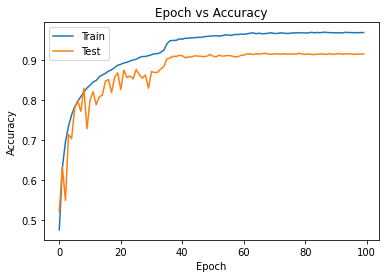

In [ ]:
plt.plot(csv_log['accuracy'])
plt.plot(csv_log['val_accuracy'])
plt.title('Epoch vs Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])

**Loss Plot**

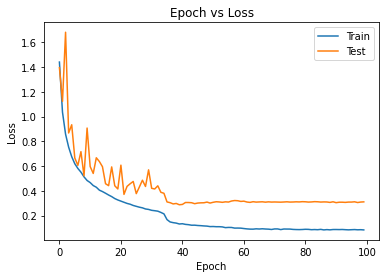

In [ ]:
plt.plot(csv_log['loss'])
plt.plot(csv_log['val_loss'])
plt.title('Epoch vs Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])